In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)


In [12]:
df = pd.read_csv("../../data/processed/telco_clean.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,1,...,1,1,1,1,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,2,...,2,1,1,1,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,2,...,1,1,1,1,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,2,...,2,2,1,1,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,1,...,1,1,1,1,Month-to-month,1,Electronic check,70.70,151.65,1


In [13]:
X = df.drop(columns=['Churn','customerID'])
y = df['Churn']
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
categorical_cols, numerical_cols

(Index(['gender', 'MultipleLines', 'InternetService', 'Contract',
        'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges',
        'TotalCharges'],
       dtype='object'))

In [14]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [15]:
df = df.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [16]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)


In [17]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', gb_model)
])


In [18]:
gb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'MultipleLines', 'InternetService', 'Contract',
       'PaymentMethod'],
      dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=200,
                                            random_state=42))])

In [19]:
y_pred = gb_pipeline.predict(X_test)
y_prob = gb_pipeline.predict_proba(X_test)[:, 1]


In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7967306325515281
Precision: 0.6419354838709678
Recall: 0.5320855614973262
F1 Score: 0.5818713450292398
ROC-AUC: 0.8412442861506128

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [21]:
confusion_matrix(y_test, y_pred)


array([[922, 111],
       [175, 199]])

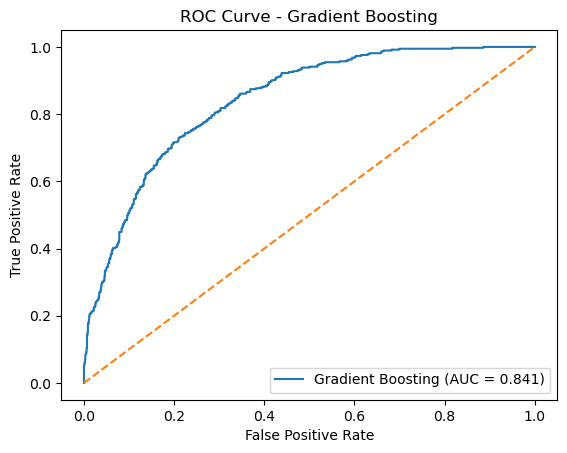

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()
